# Prepare Data

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from src.dataset import StreetViewDataset

DATASET_DIR = "data/raw/streetview_images"
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.2
RANDOM_SEED = 42
BATCH_SIZE = 32

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

dataset = StreetViewDataset(DATASET_DIR, transform=transform)
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = int(VAL_SPLIT * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_set, val_set, test_set = random_split(
  dataset,
  [train_size, val_size, test_size],
  generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, BATCH_SIZE)
test_loader = DataLoader(test_set, BATCH_SIZE)

In [2]:
# Example for one sample
image, label = dataset[1823]
print("Image:", image)
print("Class:", label)

Image: tensor([[[0.6941, 0.6941, 0.6941,  ..., 0.4157, 0.4157, 0.4157],
         [0.6980, 0.6980, 0.6980,  ..., 0.4196, 0.4196, 0.4196],
         [0.7020, 0.7020, 0.7020,  ..., 0.4235, 0.4235, 0.4235],
         ...,
         [0.5137, 0.5098, 0.4235,  ..., 0.4667, 0.4235, 0.2353],
         [0.5059, 0.5765, 0.5490,  ..., 0.3098, 0.3294, 0.1882],
         [0.5176, 0.5098, 0.5255,  ..., 0.1451, 0.1608, 0.1451]],

        [[0.7765, 0.7765, 0.7765,  ..., 0.5725, 0.5725, 0.5725],
         [0.7804, 0.7804, 0.7804,  ..., 0.5765, 0.5765, 0.5765],
         [0.7843, 0.7843, 0.7843,  ..., 0.5804, 0.5804, 0.5804],
         ...,
         [0.5216, 0.5176, 0.4314,  ..., 0.4706, 0.4275, 0.2392],
         [0.5137, 0.5843, 0.5569,  ..., 0.3137, 0.3333, 0.1922],
         [0.5255, 0.5176, 0.5333,  ..., 0.1490, 0.1647, 0.1490]],

        [[0.8980, 0.8980, 0.8980,  ..., 0.7725, 0.7725, 0.7725],
         [0.9020, 0.9020, 0.9020,  ..., 0.7765, 0.7765, 0.7765],
         [0.9059, 0.9059, 0.9059,  ..., 0.7804, 0.7

In [3]:
# Example of dataloader batch
for batch_images, batch_labels in train_loader:
    print("Batch images shape:", batch_images.shape)
    print("Batch labels:", batch_labels)

    # Convert ID to country string
    idx_to_name = {v: k for k, v in dataset.label_map.items()}
    for lbl in batch_labels[:5]:
        print("Label:", lbl.item(), "Country:", idx_to_name[lbl.item()])

    break

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([  4,  82,  59,  82, 110, 100,   3,  58,  68,  29,  57,  83,  97,  52,
         30,  72,  96,  35,  19,  96,  97,  60, 109,  11,  27,  60,  59,  25,
         50,  30,  20,  25])
Label: 4 Country: American Samoa
Label: 82 Country: Peru
Label: 59 Country: Liechtenstein
Label: 82 Country: Peru
Label: 110 Country: South Africa


# Initialize Model

In [2]:
import torch.nn as nn
from src.model import ResNet50Model

num_classes = len(dataset.label_map)

model = ResNet50Model(num_classes, pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

e:\Projects\CountryGuessr\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Projects\CountryGuessr\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train Model

In [3]:
import os
from torch.utils.tensorboard import SummaryWriter
from src.train import train_epoch, validate_epoch

NUM_EPOCHS = 10
writer = SummaryWriter("runs/country_classifier")
global_step = 0

for epoch in range(NUM_EPOCHS):
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, writer, global_step)
  val_loss, val_acc = validate_epoch(model, val_loader, criterion, device, writer, global_step)

  writer.add_scalar("Loss/Train", train_loss, epoch)
  writer.add_scalar("Loss/Validation", val_loss, epoch)
  writer.add_scalar("Accuracy/Train", train_acc, epoch)
  writer.add_scalar("Accuracy/Validation", val_acc, epoch)

  os.makedirs("model", exist_ok=True)
  checkpoint = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "label_map": dataset.label_map
  }
  torch.save(checkpoint, f"model/country_classifier_{epoch+1}.pt")

  print(f"Epoch {epoch+1}:")
  print(f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")
  print(f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/

# Load Model for Inference  

In [ ]:
checkpoint = torch.load('model/country_classifier_1.pt')
model = ResNet50Model(num_classes=len(checkpoint["label_map"]), pretrained=False)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

e:\Projects\CountryGuessr\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Projects\CountryGuessr\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50Model(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

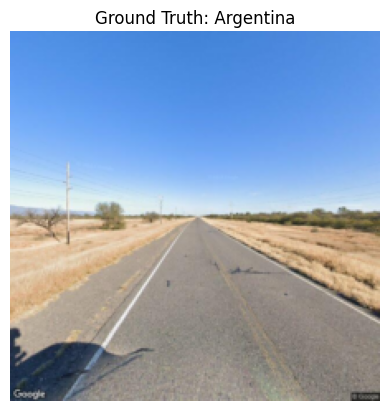

Predicted probabilities:
United States: 57.27%
Argentina: 25.91%
Australia: 7.94%
Mexico: 3.53%
Namibia: 1.42%


In [73]:
import matplotlib.pyplot as plt
import numpy as np
import random

idx = random.randint(0, len(test_set) - 1)
top_k = 5

model.eval()
image, label = dataset[idx]
image_tensor = image.unsqueeze(0).to(device) 

with torch.no_grad():
    outputs = model(image_tensor)
    probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

topk_indices = probabilities.argsort()[-top_k:][::-1]
topk_probs = probabilities[topk_indices]

idx_to_name = {v: k for k, v in dataset.label_map.items()}
topk_countries = [idx_to_name[i] for i in topk_indices]

gt_country = idx_to_name[label]

plt.imshow(np.transpose(image.numpy(), (1, 2, 0))) 
plt.axis('off')
plt.title(f"Ground Truth: {gt_country}")
plt.show()

print("Predicted probabilities:")
for country, prob in zip(topk_countries, topk_probs):
    print(f"{country}: {prob*100:.2f}%")
